Вспомогательный флаг для удобства использования на раных платформах

In [157]:
# True - для Google Colab
# False - для Kaggle
is_colab = True

# Прогнозирование стоимости автомобиля по характеристикам
Цель:  
Разработать Multi-input модель для предсказания стоимости автомобиля по различным данным - табличным, текстовым и графическим.

Задачи:  


## Этапы проекта:


# 0. Установка и загрузка библиотек

In [158]:
!pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [159]:
# аугментации изображений
!pip install albumentations -q

In [160]:
!pip install pymorphy2
!pip install pymorphy2-dicts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [161]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [162]:
!pip install category_encoders


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [163]:
!pip install git+https://github.com/titu1994/tf-TabNet.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/titu1994/tf-TabNet.git to /tmp/pip-req-build-qd_fccw8
  Running command git clone --filter=blob:none --quiet https://github.com/titu1994/tf-TabNet.git /tmp/pip-req-build-qd_fccw8
  Resolved https://github.com/titu1994/tf-TabNet.git to commit 58854410baade338c924382c3a9ff6b685810751
  Preparing metadata (setup.py) ... done


# Импорты

In [164]:
import os
import re
import cv2 
import sys
import csv
import random
import pickle
import zipfile
import pymorphy2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split

from category_encoders.binary import BinaryEncoder
from category_encoders import LeaveOneOutEncoder
from category_encoders.helmert import HelmertEncoder


# keras
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
import albumentations as a

from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras.callbacks import (
    Callback, 
    ModelCheckpoint, 
    EarlyStopping,
    ReduceLROnPlateau,
    LearningRateScheduler, 
)
from tensorflow.keras.optimizers.schedules import *

from tabnet import TabNetRegression

import PIL
from PIL import ImageOps, ImageFilter

# plt
import matplotlib.pyplot as plt
# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

#pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

In [165]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [166]:
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tqdm import tqdm

# Версии

Посмотрим версии используемых библиотек

In [167]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.13 (default, Apr 24 2022, 01:04:09) 
Numpy        : 1.21.6
Tensorflow   : 2.8.2


Зафиксируем версию пакетов:

In [168]:
!pip freeze > requirements.txt

# Основные настройки

In [169]:
# ACTIVATION           = 'sigmoid' # функция активации
# ACTIVATION           = 'tanh' # функция активации
# ACTIVATION           = 'relu' # функция активации
ACTIVATION           = L.LeakyReLU(0.15) # функция активации
BATCH_SIZE           = 512  # размер батча
EPOCHS               = 500  # количество эпох для обучения

Установим random seed:

In [170]:
RANDOM_SEED = 13
np.random.seed(RANDOM_SEED)

# Вспомогательные функции

Пропишем функцию для вычисления метрики MAPE

In [171]:
def mape(y_test, y_pred):
    return np.mean(np.abs((y_pred-y_test)/y_test))

In [172]:
def veiw_sample_predicts(pred, y_test):
    for i in range(20):
      print("Сеть предсказала: ", pred[i][0], 
            ", верный ответ: ", y_test[i], 
            ", отклонение: ", pred[i][0] - y_test[i])


In [173]:
def make_save(model, name):
    if is_colab:
        path = SAVE_PATH        
    else:
        path = WORK_PATH
    model.load_weights(os.path.join(path, name+'_best.hdf5'))
    model.save(os.path.join(path, name+'_final.hdf5'))
    
    return model

In [174]:
def make_sub(model, submission_df, sub, name):
    sub_predict = np.round(model.predict(sub))
    submission_df['price'] = sub_predict[:, 0]
    if is_colab:
        path = SAVE_PATH
    else:
        path = WORK_PATH
    submission_df.to_csv(os.path.join(WORK_PATH, name),
                            index=False)
    return submission_df

In [175]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    mape = history.history['MAPE']
    val_mape = history.history['val_MAPE']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(mape))

    plt.figure(figsize=(10,5))

    plt.plot(epochs, mape, 'b', label='Training mape')
    plt.plot(epochs, val_mape, 'g', label='Validation mape')
    plt.title('Training and validation mape')
    plt.legend()

    # plt.plot(epochs, loss, 'b', label='Training loss')
    # plt.plot(epochs, val_loss, 'g', label='Validation loss')
    # plt.title('Training and validation loss')
    #plt.style.use('dark_background')
    plt.legend()

    plt.show()

# Загружаем данные

Пути к данным и рабочим папкам

In [176]:
if is_colab:
    from google.colab import drive
    drive.mount('/content/drive')

if is_colab:
    # Colab
    DATA_PATH = os.path.abspath('/content/drive/MyDrive/Colab Notebooks'
                                '/project_8/input'
                                '/sf-dst-car-price-prediction-part2/')
    SAVE_PATH = os.path.abspath('/content/drive/MyDrive/Colab Notebooks'
                                '/project_8/saves')
    WORK_PATH = os.path.join(os.getcwd(), 'working')
else:
    # Kaggle
    DATA_PATH = os.path.abspath('../input/sf-dst-car-price-prediction-part2/')
    SAVE_PATH = os.path.abspath('../input/input-saves')
    WORK_PATH = os.path.abspath('./')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загрузим наш обучающий и тестовый фреймы:

In [177]:
train = pd.read_csv(os.path.join(DATA_PATH,'train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH,'test.csv'))
sample_submission = pd.read_csv(os.path.join(DATA_PATH,'sample_submission.csv'))

Объединим тестовый и обучающий фреймы в один для последующей обработки признаков:

In [178]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1  # трейн
test['sample'] = 0  # тест
test['price'] = 0  # в тесте нет значения price,  заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True)  # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


Загружаем предобработанный датафрейм чтобы не тратить время на повторную обработку.

In [179]:
if os.path.exists(SAVE_PATH):
    df = pd.read_csv(os.path.join(SAVE_PATH, 'processed_df.csv'))


In [180]:
raise KeyboardInterrupt

KeyboardInterrupt: ignored

Проверим, что у нас находится в обучающем и тестовом фреймах

In [ ]:
train.info()

In [ ]:
train.nunique()

In [ ]:
train.isna().sum()

Мы видим, что присутствуют пропуски, которые в дальнейшем придется обработать каким-либо способом.  

Проверим что находится в тестовом фрейме:

In [ ]:
test.info()

In [ ]:
test.nunique()

In [ ]:
test.isna().sum()

Здесь пропуски имеются только в столбце "владение". В дальнейшем нужно будет обработать.

In [ ]:
train.sample(7)

In [ ]:
test.sample(7)

В обоих датафреймах столбцы совпадают.

Определим типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - содержит информацию, содержащуюся в других признаках
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

Теперь попробуем создать наивную модель и посмотреть результат нашей метрики

# 2. Model 0: "Наивная" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



Первым делом проведем разделенение на обучающую и валидационную выборки:

In [ ]:
data_train, data_test = train_test_split(
    train, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

Создадим наивную модель и проведем оценку отчности:

In [ ]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 
                                          'productionDate']]).iterrows():
    predicts.append(data_train.loc[(data_train['model_info'] == row[0]) & 
                                   (data_train['productionDate'] == row[1])]
                    ['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000
# print(data_test['price'].values)
# print(predicts.values[:, 0])

# оцениваем точность
print(f"Ошибка по метрике MAPE: "
      f"{(mape(data_test['price'].values, predicts.values[:, 0]))*100:0.2f}%")


Мы получили достаточно плохой результат, но теперь появилось понимание - откуда отталкиваться. 

Первым делом проведем EDA и попробуем использовать CatBoost.

# 3. EDA и Feature-Engeneering

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм. По большей части EDA и Feature-Engeneering был произведен в одном из предыдущих проектов CarPricePrediction, поэтому многие вещи будут заимствованы оттуда.

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

## Предобработка табличных данных

## Сначала поработаем с числовыми признаками. 

### engineDisplacement

Этот признак описывает объем двигателя авто. Посмотрим количество уникальных значений :

In [ ]:
data.engineDisplacement.unique()

Мы видим, что признак отражает литраж двигателя с припиской LTR. Попробуем ее убрать:

In [ ]:
data.engineDisplacement = data.engineDisplacement.apply(lambda x: x[:3])

In [ ]:
data.engineDisplacement.value_counts()

Мы видим, что 6 значений имеют und ( остаток от undefined LTR). Заполним значением моды:

In [ ]:
data.engineDisplacement = data.engineDisplacement.replace(
    'und', data.engineDisplacement.mode()[0])

Проверим результат:

In [ ]:
data.engineDisplacement.unique()

Преобразуем в числовой формат и посмотрим распределение:

In [ ]:
data.engineDisplacement = data.engineDisplacement.apply(lambda x: float(x))

In [ ]:
data.engineDisplacement.hist()

Как мы видим, распределение близко к нормальному, но возможно после логарифмирования показатели станут лучше.

### enginePower

Признак отражает мощность двигателя автомобиля. Посмотрим на уникальные значения:

In [ ]:
data.enginePower.unique()

Избавимся от дополнительной информации в данных:

In [ ]:
data['enginePower'] = data['enginePower'].apply(lambda x: str(x).replace(' N12', ''))

Проверим результат:

In [ ]:
data.enginePower.unique()

Замечательно, теперь переведем в числовой формат и посмотрим распределение значений:

In [ ]:
data['enginePower'] = data['enginePower'].apply(lambda x: int(x))
data.enginePower.hist()

Распределение близко к нормальному, но возможно необходимо будет логарифмировать для улучшения показателей. Отнесем к числовым признакам

### mileage

Признак содержит данные о пробеге продаваемого авто. Проверим данные:

In [ ]:
data.mileage.unique()

Данные чистые. Посмотрим на распределение признака:

In [ ]:
data.mileage.hist(figsize=(8, 5), bins=100)

Проверим на выбросы:

In [ ]:
IQR = data['mileage'].quantile(0.75) - data['mileage'].quantile(0.25)
perc25 = data['mileage'].quantile(0.25)  # 25-й перцентиль
perc75 = data['mileage'].quantile(0.75)  # 75-й перцентиль

print(
    '25-й перцентиль: {},'.format(perc25),
    '75-й перцентиль: {},'.format(perc75),
    "IQR: {}, ".format(IQR),
    "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR,
                                           l=perc75 + 1.5*IQR))

Посмотрим, сколько значений превышает границу:

In [ ]:
data.mileage[data.mileage > 328841].count()

Как мы видим, значений действительно мало. Возможно они действительно являются выбросами, но существуют автомобили, у которых очень большой пробег. Поэтому предполагаемые выбросы оставим без изменений.

### modelDate

Данный признак содержит информацию о годе производства модели авто. Просмотрим уникальные значения:

In [ ]:
data.modelDate.unique()

Создадим признак - возраст автомобиля и заменим им текущий признак.

In [ ]:
datetime.now().year

In [ ]:
data['model_time'] = data['modelDate'].apply(lambda x: datetime.now().year - x)

Теперь построим график распределения для наглядности:

In [ ]:
data['model_time'].hist()

### productionDate

Признак содержит информацию о годе производства авто. Проверим корреляцию между productionDate и model_time:

In [ ]:
data[['model_time', 'productionDate']].corr()

Очевидно, высокая корреляция. Для модели будет более чем достаточно признака model_time. productionDate можно удалять.

### Владение

Данный столбец отражает,сколько времени продавец владеет автомобилем. Посмотрим, сколько пропусков в данном столбце:

In [ ]:
data.Владение.isna().sum()

Посмотрим соотношение пропусков ко всему дата-сету:

In [ ]:
data.Владение.isna().sum()/len(data.Владение)*100

Как видно, пропусков почти 65% дата-сета. Заполнение их каким-либо одним значением сыграет только плохую роль. Лучше данный столбец вообще не включать в обучение.

Посмотрим, как выглядят распределения числовых признаков:

In [ ]:
data[['mileage', 'modelDate', 'engineDisplacement', 'enginePower']]

## Теперь рассмотрим категориальные признаки.

### bodyType

Данный столбец отражает тип кузова автомобиля. Посмотрим на количество вариантов:

In [ ]:
data['bodyType'].unique()

Проведем обработку данных:

In [ ]:
# Выбираем первое слово для описания типа кузова
data['bodyType'] = data['bodyType'].astype(
    str).apply(lambda x: None if x.strip() == '' else x)
# Понижаем регистр первого слова
data['bodyType'] = data['bodyType'].apply(lambda x: x.split(' ')[0].lower())

Проверим распределение значений по типу кузова:

In [ ]:
data['bodyType'].value_counts().plot.barh()

### brand

Данный столбец отражает название фирмы-производителя автомобиля. Проверим уникальные значения:

In [ ]:
data['brand'].unique()

Как мы видим, уникальных значений мало, можно оставить без изменений. Посмотрим распределение значений:

In [ ]:
data['brand'].value_counts().plot.barh()

### color

Данный признак отражает цвет продаваемого автомобиля.  
Посмотрим уникальные значения и их количество:

In [ ]:
data['color'].unique()

In [ ]:
data['color'].nunique()

Посмотрим распределение значений по цветам:

In [ ]:
data['color'].value_counts().plot.barh()

### fuelType

Данный признак содержит данные о типе топлива, используемого в автомобиле. Посмотрим на уникальные значения:


In [ ]:
data['fuelType'].value_counts()

Посмотрим распределение признака:

In [ ]:
data['fuelType'].hist()

Как видно из графика, подавляющее большинство автомобилей используют бензиновое топливо. Отнесем признак к категориальным.

### model_info

Данный столбец отражает информацию о модели продаваемого автомобиля. Посмотрим количество уникальных значений:

In [ ]:
data['model_info'].value_counts()

Мы имеем одну строчку без указания модели. Посмотрим, что это за строка:

In [ ]:
data.loc[data['model_info'] == 'None']

Видим, что это Mercedes-седан. Посмотрим, возможно в комментарии указана модель:

In [ ]:
data.iloc[2803]['description']

Посмотрим на фотографию автомобиля и попробуем по изображению найти информацию о модели в интернете.

In [ ]:
im = PIL.Image.open(os.path.join(DATA_PATH, 'img', 'img', '1099323364.jpg'))

plt.subplot(1, 1, 1)
plt.subplots_adjust(hspace=0.5)
plt.imshow(im)
plt.show()

Исходя из имеющихся об автомобиле данных и его изображении скорее всего это Mercedes-Benz E-Класс AMG 63 AMG S IV. Отсюда следует что признако можно заполнить значением E_KLASSE.

In [ ]:
data['model_info'] = 'E_KLASSE'

### name

Столбец дублирует информацию из других столбцов. Единственное, что можно из него выделить - это наличие xDrive в автомобиле. Создадим новый признак:

In [ ]:
data['xDrive'] = data['name'].apply(lambda x: 1 if 'xDrive' in x else 0)

Посмотрим как распределен признак:

In [ ]:
sns.countplot(x='xDrive', data=data)

Как мы видим, большая часть представленных автомобилей не имеет xDrive. Отнесем к бинарным признакам.

### numberOfDoors

Признак содержит информацию о количестве дверей авто. Посмотрим на уникальные значения:

In [ ]:
data['numberOfDoors'].unique()

Как видно, никаких значений, вызывающих сомнения, нет. Проверим распределение признака:

In [ ]:
sns.countplot(x='numberOfDoors', data=data)

In [ ]:
data['numberOfDoors'] = data['numberOfDoors'].astype('object')

### vehicleConfiguration

In [ ]:
data['vehicleConfiguration']

Столбец содержит информацию из других столбцов. Информативности не несет. Признак можно удалить.

### Владельцы

In [ ]:
data['Владельцы'].unique()

Признак содержит информацию о количестве владельцев авто. Посмотрим пропуски:

In [ ]:
data['Владельцы'].isna().sum()

Всего один пропуск. Посмотрим, что это за строка:

In [ ]:
data[data['Владельцы'].isnull()]

Посмотрим описание, возможно там указано, сколько было владельцев:

In [ ]:
data.iloc[6665]['description']

К сожалению, комментарий оказался неинформативен. Заполним значение модой:

In [ ]:
data['Владельцы'].fillna(data['Владельцы'].mode()[0], inplace=True)

Посмотрим результат:

In [ ]:
data['Владельцы'].isna().sum()

Теперь оставим только числовые значения и приведем к числовому виду столбец:

In [ ]:
data['Владельцы'] = data['Владельцы'].apply(lambda x: int(str(x)[0]))

Посмотрим распределение:

In [ ]:
data['Владельцы'].hist()

Видно что автомобили с 3 владельцами немного преобладают над всеми остальными, но не сильно.

Т.к. значения данного признака можно сравнивать между собой, заменим значения на те, что больше отражают суть признака - чем больше владельцев у авто, тем хуже. Для этого заменим:  
1 - на 0,  
2 - на -1,  
3 - на -2.

In [ ]:
data['Владельцы'] = data['Владельцы'].apply(lambda x: x - (x*2-1))

In [ ]:
data['Владельцы'].hist()

### vehicleTransmission

Признак содержит информацию о типе коробки передач, используемой в транспортном средстве. Проверим уникальные значения:

In [ ]:
data['vehicleTransmission'].unique()

Посмотрим распределение признака:

In [ ]:
sns.countplot(x='vehicleTransmission', data=data)

Подавляющее большинство автомобилей имеют автоматическую коробку передач.

### ПТС

Данный признак содержит информацию о ПТС автомобиля. Проверим уникальные значения:

In [ ]:
data['ПТС'].unique()

Выведем график распределения признака:

In [ ]:
data.ПТС.hist()

Как видно из распределения - большая часть продавцов имеет оригинал ПТС. Пропусков не наблюдается.

### Привод

Признак содержит информацию о том, какой привод у транспортного средства. Посмотрим график распределения признака:

In [ ]:
sns.countplot(x='Привод', data=data)

Видно, что большинство автомобилей имеют полный привод.

### Руль

Признак отражает положение руля в автомобиле. Посмотрим распределение признака:

In [ ]:
sns.countplot(x='Руль', data=data)

Почти все автомобили имеют левый руль.

Остался текстовый признак и признак, указывающий на соответствующую фотографию автомобиля.

### description

Данный столбец содержит комментарий о продаваемом автомобиле. В дальнейшем будет использоваться для NLP. Сейчас выделим на основе этого столбца признак, отражающий длину комментария:

In [ ]:
data['comment_length'] = data.description.apply(lambda x: len(str(x)))

In [ ]:
data.comment_length.hist()

Отнесем к числовым признакам

### sell_id

Этот признак нам в дальнейшем пригодится для того, чтобы находить изображения по идентификатору объявления. Для табличного обучения информативности не имеет.

### Целевой признак - price

Посмотрим график распределения целевого признака:

In [ ]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.title(f"Histogramma {'price'}")
sns.distplot((data[data['sample'] == 1]['price']), bins=50)

plt.subplot(1, 2, 2)
sns.boxplot(data['price'])
plt.xlabel('Price')
plt.title(f"Boxplot {'price'}", fontsize=12)
plt.show()
data.price.describe()

Видно, что данные сильно смещены влево. Посмотрим, как будет себя вести признак после логарифмирования:

In [ ]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.title(f"Histogramma log.{'price'} ")
sns.distplot(np.log(data[data['sample'] == 1]['price']), bins=50)

plt.subplot(1, 2, 2)
sns.boxplot(np.log(data[data['sample'] == 1]['price']))
plt.xlabel('Price')
plt.title('Boxplot log.price', fontsize=12)
plt.show()

Теперь посмотрим зависимости некоторых столбцов от целевого:

Зависимость от возраста авто.

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter((data.price), data.modelDate)

Из распределения видно, что чем более "свежий" автомобиль, тем выше на него цена. Но опять же, некоторые более старые автомобили могут стоить дорого из-за раритетности.  
Посмотрим также зависимость от привода:

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter((data.price), data['Привод'])

Из распределения хорошо видно, что наиболее высокая цена у полного привода, что логично.

Теперь сформируем перечень числовых признаков:




In [ ]:
# числовые признаки
num_features = ['mileage', 'model_time', 'engineDisplacement', 
                'enginePower', 'comment_length']

Необходимо посмотреть корреляционную зависимость наших признаков:

In [ ]:
plt.figure(figsize=(12, 7))
sns.heatmap(data[data['sample'] == 1]
            [num_features + ['price']].corr(), annot=True)

Больше всего на таргет влияют признаки mileage, model_time, enginePower.  
Прослеживается высокая корреляция между мощньстью и объёмом двигателя, что очевидно. Однако, на мой взгляд она не достаточно высока, чтобы удалять один из признаков.

# Финальный этап обработки данных:

## Распределение числовых признаков.

In [ ]:
def visualize_distributions(titles_values_dict):
    columns = min(3, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize=(columns * 6, rows * 4))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins=20)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.bar(bins[:-1], hist, width=(bins[1] - bins[0]) * 0.7)
        ax.set_title(title)
    plt.show()


visualize_distributions({
    'mileage': data['mileage'].dropna(),
    'modelDate': data['modelDate'].dropna(),
    'engineDisplacement': data['engineDisplacement'].dropna(),
    'enginePower': data['enginePower'].dropna(),
    'comment_length': data['comment_length'].dropna()
})

## Просмотрим распределение после логарифмирования:

In [ ]:
visualize_distributions({
    'mileage': np.log10(data['mileage'].dropna()),
    'modelDate': np.log10(data['modelDate'].dropna()),
    'engineDisplacement': np.log10(data['engineDisplacement'].dropna()),
    'enginePower': np.log10(data['enginePower'].dropna()),
    'comment_length': np.log10(data['comment_length'].dropna())
})

Распределения стали выглядеть лучше. Таким образом перед нормализацией возьмём логарифм для каждого числового признака.

## Тестируем масштабаторы.

In [ ]:
MinMaxScaler, RobustScaler, StandardScaler
scaler1 = StandardScaler()
scaler2 = MinMaxScaler()
scaler3 = RobustScaler()

scaler = scaler1

visualize_distributions({
    'mileage': scaler.fit_transform(np.log10(data[['mileage']].dropna()))[:, 0],
    'modelDate': scaler.fit_transform(np.log10(data[['modelDate']].dropna()))[:, 0],
    'engineDisplacement': scaler.fit_transform(np.log10(data[['engineDisplacement']].dropna()))[:, 0],
    'enginePower': scaler.fit_transform(np.log10(data[['enginePower']].dropna()))[:, 0],
    'comment_length': scaler.fit_transform(np.log10(data[['comment_length']].dropna()))[:, 0]
})

In [ ]:
scaler = scaler2

visualize_distributions({
    'mileage': scaler.fit_transform(np.log10(data[['mileage']].dropna()))[:, 0],
    'modelDate': scaler.fit_transform(np.log10(data[['modelDate']].dropna()))[:, 0],
    'engineDisplacement': scaler.fit_transform(np.log10(data[['engineDisplacement']].dropna()))[:, 0],
    'enginePower': scaler.fit_transform(np.log10(data[['enginePower']].dropna()))[:, 0],
    'comment_length': scaler.fit_transform(np.log10(data[['comment_length']].dropna()))[:, 0]
})

In [ ]:
scaler = scaler3

visualize_distributions({
    'mileage': scaler.fit_transform(np.log10(data[['mileage']].dropna()))[:, 0],
    'modelDate': scaler.fit_transform(np.log10(data[['modelDate']].dropna()))[:, 0],
    'engineDisplacement': scaler.fit_transform(np.log10(data[['engineDisplacement']].dropna()))[:, 0],
    'enginePower': scaler.fit_transform(np.log10(data[['enginePower']].dropna()))[:, 0],
    'comment_length': scaler.fit_transform(np.log10(data[['comment_length']].dropna()))[:, 0]
})

Лучше всего себя показал StandartScaler. Поэтому в финальной обработке будем использовать его.

In [ ]:
def process_data(df_input):

    df_output = df_input.copy()

    # Удалим неиспользуемые столбцы
    df_output.drop(['modelDate', 'productionDate', 'description', 'sell_id', 
                    'vehicleConfiguration', 'Владение', 'name', ],
                    axis=1, inplace=True)

    ############################### Нормализация ###############################

    scaler = StandardScaler()
    for column in num_features:
        df_output[column] = scaler.fit_transform(
            df_output[[column]])[:, 0]

    # scaler = RobustScaler()
    # for column in num_features:
    #     df_output[column] = scaler.fit_transform(
    #         df_output[[column]])[:,0]
    
    return df_output

# Категориальные признаки

Изначально планировалось разбить категориальные признаки на логические группы:  
- {brand, ПТС, Привод, Руль} будут закодированы с помощью One-Hot Encoder;
- {fuelType, numberOfDoors, vehicleTransmission} будут закодированы с помощью BinaryEncoder;
- {bodyType, color, model_info} будут закодированы с помощью Target Encoder реализованного под капотом CatBoost;  
Такой подход дал хорошие результаты для CatBoost, но нейронные сети обучались очень плохо.  

Далее я попробовал преобразовать все категориальные признаки методом Leave_One_Out - ни одна модель не меняла результаты.

В итоге, я выбрал обработать признаки для каждых типов моделей соответственно:  
- Для CatBoost выбрал обработку с разбиением на логические группы;
- Для DNN выбрал обработку простым One-Hot Encoder.  


## Преобразование числовых признаков

In [ ]:
df = process_data(data)

In [181]:
df

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,model_info,numberOfDoors,vehicleTransmission,Владельцы,ПТС,Привод,Руль,sample,price,model_time,xDrive,comment_length
0,универсал,MERCEDES,чёрный,0.209436,-0.326606,бензин,2.805524,E_KLASSE,5,автоматическая,-2,Оригинал,задний,Левый,0,0.0,4.801459,0,1.405358
1,купе,BMW,белый,0.209436,0.527566,дизель,-1.287242,E_KLASSE,2,автоматическая,0,Оригинал,полный,Левый,0,0.0,-0.164891,1,-0.240558
2,купе,BMW,пурпурный,-0.264148,-0.344976,бензин,0.564887,E_KLASSE,2,автоматическая,-2,Оригинал,полный,Левый,0,0.0,0.938742,0,0.142259
3,седан,BMW,белый,-0.737732,-1.098117,бензин,0.325430,E_KLASSE,4,автоматическая,-1,Оригинал,задний,Левый,0,0.0,0.938742,0,-0.619388
4,седан,BMW,чёрный,-0.737732,-0.602146,дизель,-1.177287,E_KLASSE,4,автоматическая,0,Оригинал,полный,Левый,0,0.0,-1.084585,1,-0.008276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8348,седан,BMW,серый,-0.737732,-0.969532,бензин,1.373386,E_KLASSE,4,автоматическая,-2,Оригинал,задний,Левый,1,550000.0,0.938742,0,-0.449912
8349,седан,BMW,чёрный,-0.737732,-0.602146,дизель,-1.058780,E_KLASSE,4,автоматическая,-2,Оригинал,задний,Левый,1,1900000.0,-0.532769,0,-0.059119
8350,седан,BMW,белый,-0.737732,-1.033824,бензин,0.972942,E_KLASSE,4,автоматическая,-2,Оригинал,задний,Левый,1,530000.0,0.386926,0,-0.668238
8351,седан,AUDI,чёрный,0.209436,0.500012,бензин,-0.590861,E_KLASSE,4,автоматическая,-2,Оригинал,полный,Левый,1,1970000.0,-0.532769,0,-0.255512


In [ ]:
if is_colab:
    df.to_csv(os.path.join(SAVE_PATH, 'processed_df.csv'),
                               index=False)
else:
    df.to_csv(os.path.join(WORK_PATH, 'processed_df.csv'),
                               index=False)

In [ ]:
raise KeyboardInterrupt

# Model 1: CatBoostRegressor

## Категориальные признаки

In [182]:
features_for_OneHot_Encoder = ['brand', 'ПТС', 'Привод', 'Руль', 'Владельцы']
features_for_BinaryEncoder = ['fuelType', 'numberOfDoors', 'vehicleTransmission']
features_for_CatBoost = ['bodyType', 'color', 'model_info']

Преобразуем категориальные признаки для CatBoost модели.

In [183]:
# One-Hot Encoding:
df = pd.get_dummies(
    df, columns=features_for_OneHot_Encoder, dummy_na=False)

# Binary Encoding
bn = BinaryEncoder(cols=features_for_BinaryEncoder)
df = bn.fit_transform(df)

## Разделим данные

In [184]:
train_df = df.loc[df["sample"] == 1].drop("sample", axis=1)
test_df = df.loc[df["sample"] == 0].drop(['sample'], axis=1)

X = train_df.drop(['price'], axis=1)
y = train_df['price'].values
sub = test_df.drop(['price'], axis=1)


Разделим train на обучающую и валидационную выборку. На валидацию выделим 25%.

In [185]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, random_state=RANDOM_SEED)

In [186]:
# raise KeyboardInterrupt

## Обучение

Теперь обучим наш CatBoosRegressor:

In [ ]:
cat_boost_model = CatBoostRegressor(iterations=20000,
                          depth=13,
                          learning_rate = 0.001,
                          random_seed=RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,  # Прерывание, если метрика не меняется
                          # task_type='GPU',
                          silent=True,
                          l2_leaf_reg=6, 
                          random_strength=0.3,
                          cat_features=features_for_CatBoost
                          )
# обучим модель
cat_boost_model.fit(X_train, np.log(y_train),
          eval_set=(X_test, np.log(y_test)),
          verbose_eval=100,
          use_best_model=True,
          )

# cat_boost_model.fit(X_train, (y_train),
#           eval_set=(X_test, (y_test)),
#           verbose_eval=100,
#           use_best_model=True,
#           )

# оцениваем точность
predict_catboost = np.round(np.exp(cat_boost_model.predict(X_test)))
print("Точность модели по метрике MAPE: "
      f"{(mape(y_test, predict_catboost))*100:0.2f}%")


0:	learn: 0.0427431	test: 0.0423725	best: 0.0423725 (0)	total: 200ms	remaining: 1h 6m 44s
100:	learn: 0.0396948	test: 0.0393543	best: 0.0393543 (100)	total: 18.7s	remaining: 1h 1m 24s
200:	learn: 0.0369418	test: 0.0366323	best: 0.0366323 (200)	total: 37.3s	remaining: 1h 1m 10s
300:	learn: 0.0344445	test: 0.0341767	best: 0.0341767 (300)	total: 56.2s	remaining: 1h 1m 15s
400:	learn: 0.0321608	test: 0.0319277	best: 0.0319277 (400)	total: 1m 15s	remaining: 1h 1m 10s
500:	learn: 0.0300729	test: 0.0298762	best: 0.0298762 (500)	total: 1m 33s	remaining: 1h 51s
600:	learn: 0.0281601	test: 0.0279942	best: 0.0279942 (600)	total: 1m 52s	remaining: 1h 42s
700:	learn: 0.0264325	test: 0.0262935	best: 0.0262935 (700)	total: 2m 12s	remaining: 1h 51s
800:	learn: 0.0248440	test: 0.0247313	best: 0.0247313 (800)	total: 2m 31s	remaining: 1h 40s
900:	learn: 0.0234031	test: 0.0233188	best: 0.0233188 (900)	total: 2m 52s	remaining: 1h 49s
1000:	learn: 0.0220942	test: 0.0220378	best: 0.0220378 (1000)	total: 3m 1

## Валидация

In [ ]:
test_predict_catboost = np.round(np.exp(cat_boost_model.predict(X_test)))
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

In [ ]:
for i in range(20):
      print("Сеть предсказала: ", test_predict_catboost[i], 
            ", верный ответ: ", y_test[i], 
            ", отклонение: ", test_predict_catboost[i] - y_test[i])

Сохраним предсказание для финального этапа.

In [ ]:
if is_colab:
    path = SAVE_PATH
else:
    path = WORK_PATH

pd.DataFrame(test_predict_catboost).to_csv(os.path.join(path, 
                                                   'test_predict_cat_boost.csv'), 
                                      index=False)

Результаты неплохие.
При уменьшении learning_rate модель сильно переобучается и  результаты ухудшаются на порядок.

## Submission

Создадим сабмит:

In [ ]:
if is_colab:
    path = SAVE_PATH
else:
    path = WORK_PATH

sub_predict_catboost = np.round(np.exp(cat_boost_model.predict(sub)))

sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv(os.path.join(path, 'cat_boost_sub.csv'), 
                         index=False)

In [ ]:
raise KeyboardInterrupt

# Обработка категориальных признаков для нейронных сетей

In [ ]:
# категориальные признаки
features_cat = ['brand', 'ПТС', 'Привод', 'Руль', 'fuelType', 
                'numberOfDoors', 'vehicleTransmission', 'bodyType',
                'color', 'model_info', 'Владельцы']

In [ ]:
# One-Hot Encoding:
df = pd.get_dummies(
    df, columns=features_cat, dummy_na=False)

## Разделим данные

In [ ]:
train_df = df.loc[df["sample"] == 1].drop("sample", axis=1)
test_df = df.loc[df["sample"] == 0].drop(['sample'], axis=1)

X = train_df.drop(['price'], axis=1)
y = train_df['price'].values
sub = test_df.drop(['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
raise KeyboardInterrupt

# Model 2: Нейронная сеть

Теперь разработаем нейронную сеть для решения поставленной задачи.

In [ ]:
file_name = 'simple_dnn'

In [ ]:
simple_dnn = M.Sequential()

simple_dnn.add(L.Dense(8192, 
                       input_dim = X_train.shape[1],  
                       activation=ACTIVATION))
simple_dnn.add(L.Dropout(0.15))

simple_dnn.add(L.Dense(16384,
                       kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
                       kernel_initializer='normal', 
                       activation=ACTIVATION))
simple_dnn.add(L.Dropout(0.15))

simple_dnn.add(L.Dense(8192,
                       kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
                       kernel_initializer='normal', 
                       activation=ACTIVATION))
simple_dnn.add(L.Dropout(0.15))

simple_dnn.add(L.Dense(8192,
                       kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
                       kernel_initializer='normal', 
                       activation=ACTIVATION))
simple_dnn.add(L.Dropout(0.15))

simple_dnn.add(L.Dense(4096,
                       kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
                       kernel_initializer='normal', 
                       activation=ACTIVATION))
simple_dnn.add(L.Dropout(0.15))

simple_dnn.add(L.Dense(4096,
                       kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
                       kernel_initializer='normal', 
                       activation=ACTIVATION))
# model_mlp.add(L.Dropout(0.15))

# The Output Layer :
simple_dnn.add(L.Dense(1, activation='linear'))

In [ ]:
# simple_dnn = M.Sequential()

# simple_dnn.add(L.Dense(4096, 
#                        input_dim = X_train.shape[1],  
#                        activation=ACTIVATION))
# simple_dnn.add(L.Dropout(0.15))

# simple_dnn.add(L.Dense(4096,
#                        kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
#                        kernel_initializer='normal', 
#                        activation=ACTIVATION))
# simple_dnn.add(L.Dropout(0.15))

# simple_dnn.add(L.Dense(4096,
#                        kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
#                        kernel_initializer='normal', 
#                        activation=ACTIVATION))
# simple_dnn.add(L.Dropout(0.15))

# simple_dnn.add(L.Dense(4096,
#                        kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
#                        kernel_initializer='normal', 
#                        activation=ACTIVATION))
# simple_dnn.add(L.Dropout(0.15))

# simple_dnn.add(L.Dense(4096,
#                        kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
#                        kernel_initializer='normal', 
#                        activation=ACTIVATION))
# simple_dnn.add(L.Dropout(0.15))

# simple_dnn.add(L.Dense(4096,
#                        kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
#                        kernel_initializer='normal', 
#                        activation=ACTIVATION))
# # simple_dnn.add(L.Dropout(0.15))

# # The Output Layer :
# simple_dnn.add(L.Dense(1, activation='linear'))

In [ ]:
# # лучшая
# simple_dnn = M.Sequential()

# simple_dnn.add(L.Dense(2048, 
#                        input_dim = X_train.shape[1],  
#                        activation=ACTIVATION))
# simple_dnn.add(L.Dropout(0.15))

# simple_dnn.add(L.Dense(16384,
#                        kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
#                        kernel_initializer='normal', 
#                        activation=ACTIVATION))
# simple_dnn.add(L.Dropout(0.15))

# simple_dnn.add(L.Dense(4096,
#                        kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
#                        kernel_initializer='normal', 
#                        activation=ACTIVATION))
# simple_dnn.add(L.Dropout(0.15))

# simple_dnn.add(L.Dense(4096,
#                        kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
#                        kernel_initializer='normal', 
#                        activation=ACTIVATION))
# # simple_dnn.add(L.Dropout(0.15))

# # The Output Layer :
# simple_dnn.add(L.Dense(1, activation='linear'))

Посмотрим структуру модели:

In [ ]:
# file_name = 'simple_dnn'
# simple_dnn = keras.models.load_model(os.path.join(SAVE_PATH, 
#                                                       file_name+'.hdf5'))
# LR = 0.0001

# simple_dnn.compile(loss='MAPE', optimizer=optimizers.Adam(learning_rate=LR),
#                    metrics=['MAPE'])

In [ ]:
simple_dnn.summary()

Скомпилируем модель:

In [ ]:
LR = 0.0001

# Compile model
simple_dnn.compile(loss='MAPE', optimizer=optimizers.Adam(learning_rate=LR),
                   metrics=['MAPE'])

## Коллбеки
* EarlyStop - Для прерывания обучения в случае, когда нет положительного результата на протяжении n эпох.
* Checkpoint - Сохраняет лучшие веса модели.
* LearningRateSheduler - постепенное уменьшение LR.

In [ ]:
def scheduler(epoch, lr):
    if epoch < 10 or lr <= 0.000000001:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
if is_colab:
    path = SAVE_PATH
else:
    path = WORK_PATH
                                                 
cb_checkpoint = ModelCheckpoint(os.path.join(path, 
                                                 file_name+'_best.hdf5'), 
                                    monitor = ['val_MAPE'], 
                                    verbose = 0, mode = 'min')

cb_earlystop = EarlyStopping(monitor='val_MAPE', patience=30, verbose=1, 
                             mode='min',
                             restore_best_weights=True)
# cb_schedul = LearningRateScheduler(scheduler, verbose=1)

cb_schedul = ReduceLROnPlateau(monitor='val_MAPE',
                                 factor=tf.math.exp(-0.1),  # new_lr = lr*factor
                                 patience=1,  # эпох без изменений
                                 min_lr=0.000000001,
                                 verbose=1,  # выводить сообщения
                                 mode='max')  # способ отслеживания метрики

callbacks_list = [cb_checkpoint, cb_earlystop, cb_schedul]

## Обучение

In [ ]:
BATCH_SIZE = 16

In [ ]:
history = simple_dnn.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=1000,
                    validation_data=(X_test, y_test), 
                    callbacks=callbacks_list, 
                    verbose=1,
                    )

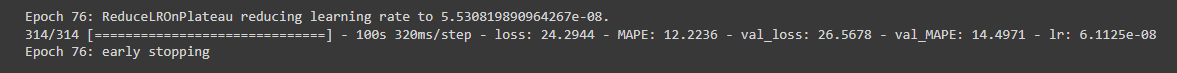

## График

Посмотрим график обучения:

In [ ]:
plot_history(history)

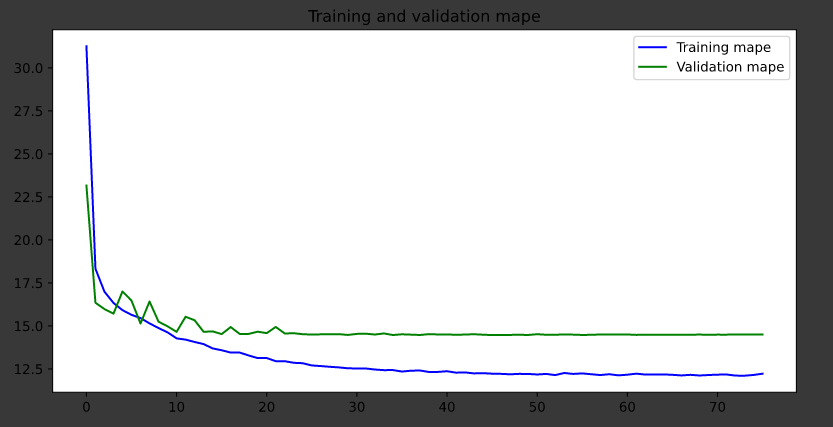

Сохраним модель и подгрузим лучшие веса:

In [ ]:
simple_dnn = make_save(simple_dnn, file_name)

## Валидация

In [ ]:
test_predict_simple_dnn = np.round(simple_dnn.predict(X_test))
print(f"TEST mape: {(mape(y_test, test_predict_simple_dnn[:,0]))*100:0.2f}%")

Сохраним предсказание для финального этапа.

In [ ]:
pd.DataFrame(test_predict_simple_dnn).to_csv(os.path.join(path, 
                                                   'test_predict_simple_dnn.csv'), 
                                      index=False)

In [ ]:
veiw_sample_predicts(test_predict_simple_dnn, y_test)


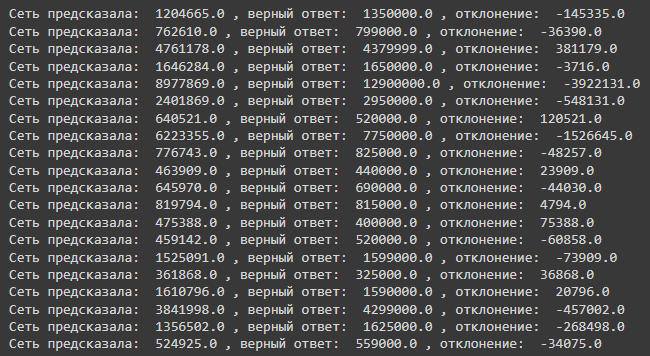

График показывает что архитектура сети не лучшая - модель переобучается, однако на валидации она показывает лучшей результат из всех опробованных архитектур.  
Проблема нейронных сетей всегда заключалась в их высокой дисперсии и склонности к переобучению.  
Нейронная сеть хорошо справляется с обучающими данными, но лучше использовать регрессию с усеченным деревом решений, которая эмулирует линейную и высокодисперсную нейронную сеть, но позволяет лучше контролировать глубину, ширину и другие атрибуты для контроля переобучения.

## Submission

In [ ]:
sample_submission = make_sub(simple_dnn, sample_submission, sub, 
                             'simple_dnn_submission.csv')

In [ ]:
sample_submission.head()

In [ ]:
raise KeyboardInterrupt

# 6. Model 3: NLP + MLP

Для данной модели мы будем использовать две сети:
* NLP для обработки столбца description
* MLP, созданная ранее, для табличных данных

Для начала посмотрим, как выглядят данные в столбце:

In [ ]:
for s in data['description'].head(5):
    print('*'*50, '\n', s)

Мы видим, что столбец представляет собой комментарий к продаваемому автомобилю. В нем присутствует мусор, от которого нужно будет избавиться. План действий будет примерно следующим:
* Очистим строки от ненужных символов
* Проведем лемматизацию строк
* Уберем стоп-слова из строк
* Проведем токенизацию текста
* Проведем векторизацию текста

## Лемматизация

Суть лемматизации заключается в том, чтобы вернуть каждое слово к его изначальной словоформе. Это нужно, чтобы не считать разные формы слова "уникальными" при обработке текста.

Загрузим морфологический анализатор и скопируем данные из исходного дата-сета:

In [ ]:
morphy = pymorphy2.MorphAnalyzer()
df_NLP = data.copy()

Создадим паттерн с "мусорными" символами в строках ( обнавлялся несколько раз в процессе обработки текста, каждый раз находились новые уникальные значения) и напишем функцию для лемматизации:

In [ ]:
# функция для лемматизации текста:
def lemma(text):
    # Паттерн с символами
    trash_sym = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-–»«•∙·✔➥●☛“”°№₽®]+"

    text = text.lower()  # понижаем регистр
    text = re.sub(trash_sym, ' ', text)  # удаляем символы из паттерна
    strings = []  # создаем массив, в котором будут храниться лемматизированные строки
    for wrd in text.split():  # берем слово из строки
        wrd = wrd.strip()  # убираем пробелы до и после слова
        wrd = morphy.normal_forms(wrd)[0]  # приводим к нормальной форме
        strings.append(wrd)  # добавляем слово в строку массива
    return ' '.join(strings)  # вернем значения, разделив пробелами


Применим функцию к нашему nlp-датасету:

In [ ]:
strings_set = []
strings_set = df_NLP.apply(
    lambda df_NLP: lemma(df_NLP['description']), axis=1)

Загрузим список русских стоп-слов:

In [ ]:
russian_stopwords = stopwords.words("russian")

Напишем функцию, которая которая будет проверять наши лемматизированные слова на наличие в списке стоп-слов:

In [ ]:
# функция для проверки на стоп-слова
def lineWithoutStopWords(line):
    line = line.split()  # разделяем на слова
    # возвращаем слово, если оно не в списке стоп-слов
    return [word for word in line if word not in russian_stopwords]


# применим функцию к нашим лемматизированым строкам слов
data['description'] = [lineWithoutStopWords(line) for line in strings_set]

In [ ]:
if is_colab:
    path = SAVE_PATH
else:
    path =  WORK_PATH
    
data['description'].to_csv(os.path.join(path, 'processed_description.csv'),
                               index=False)

In [ ]:
raise KeyboardInterrupt

## Загрузим обработанный description

In [ ]:
if os.path.exists(SAVE_PATH):
    data['description'] = pd.read_csv(os.path.join(SAVE_PATH, 
                                                  'processed_description.csv'))

In [ ]:
text_train = data['description'].iloc[X_train.index]
text_test = data['description'].iloc[X_test.index]
text_sub = data['description'].iloc[sub.index]

## Токенизация

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

Обучим токенизатор на полученном списке лемматизированых слов:

In [ ]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data['description'])

Проверим результат:

In [ ]:
tokenize.word_index

Используем полученный список слов для векторизации текста из наших выборок:

In [ ]:
%%time
text_train_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(
    tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape,
      text_test_sequences.shape, text_sub_sequences.shape, )

In [ ]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

Выведем пример того, как теперь выглядит текст:

In [ ]:
print(text_train.iloc[6])
print(text_train_sequences[6])

## NLP-сеть

In [ ]:
model_nlp = M.Sequential()

model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))

model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH))

model_nlp.add(L.LayerNormalization())

model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.15))

model_nlp.add(L.Dense(4096, 
                      kernel_regularizer=regularizers.l1_l2(l1=1e-7, l2=1e-7), 
                      kernel_initializer='normal', 
                      activation=ACTIVATION))
model_nlp.add(L.Dropout(0.15))

model_nlp.add(L.Dense(4096, 
                      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-5), 
                      kernel_initializer='normal', 
                      activation=ACTIVATION))
model_nlp.add(L.Dropout(0.15))

model_nlp.add(L.LSTM(256,))
model_nlp.add(L.Dropout(0.15))

model_nlp.add(L.Dense(8192, 
                      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-5), 
                      kernel_initializer='normal', 
                      activation=ACTIVATION))
# model_nlp.add(L.Dropout(0.15))

In [ ]:
# model_nlp = M.Sequential()

# model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))

# model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH))

# model_nlp.add(L.LayerNormalization())

# model_nlp.add(L.LSTM(256, return_sequences=True))
# model_nlp.add(L.Dropout(0.15))

# model_nlp.add(L.Dense(4096, 
#                       kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
#                       kernel_initializer='normal', 
#                       activation=ACTIVATION))
# model_nlp.add(L.Dropout(0.15))

# model_nlp.add(L.LSTM(256, return_sequences=True))
# model_nlp.add(L.Dropout(0.15))

# model_nlp.add(L.Dense(16384, 
#                       kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
#                       kernel_initializer='normal', 
#                       activation=ACTIVATION))
# model_nlp.add(L.Dropout(0.15))

# model_nlp.add(L.LSTM(256, return_sequences=True))
# model_nlp.add(L.Dropout(0.15))

# model_nlp.add(L.Dense(8192, 
#                       kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
#                       kernel_initializer='normal', 
#                       activation=ACTIVATION))
# model_nlp.add(L.Dropout(0.15))

# model_nlp.add(L.Dense(4096, 
#                       kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
#                       kernel_initializer='normal', 
#                       activation=ACTIVATION))
# model_nlp.add(L.Dropout(0.15))

# model_nlp.add(L.LSTM(256,))
# # model_nlp.add(L.Dropout(0.15))

# model_nlp.add(L.Dense(4096, 
#                       kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
#                       kernel_initializer='normal', 
#                       activation=ACTIVATION))
# # model_nlp.add(L.Dropout(0.15))

In [ ]:
# model_nlp = M.Sequential()

# model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))

# model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH))

# model_nlp.add(L.LayerNormalization())

# model_nlp.add(L.LSTM(64, return_sequences=True))
# model_nlp.add(L.Dropout(0.15))

# model_nlp.add(L.Dense(4096, 
#                       kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
#                       kernel_initializer='normal', 
#                       activation=ACTIVATION))
# model_nlp.add(L.Dropout(0.15))

# model_nlp.add(L.LSTM(64, return_sequences=True))
# model_nlp.add(L.Dropout(0.15))

# model_nlp.add(L.Dense(16384, 
#                       kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
#                       kernel_initializer='normal', 
#                       activation=ACTIVATION))
# model_nlp.add(L.Dropout(0.15))

# model_nlp.add(L.LSTM(64, return_sequences=True))
# model_nlp.add(L.Dropout(0.15))

# model_nlp.add(L.Dense(8192, 
#                       kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
#                       kernel_initializer='normal', 
#                       activation=ACTIVATION))
# model_nlp.add(L.Dropout(0.15))

# model_nlp.add(L.Dense(4096, 
#                       kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
#                       kernel_initializer='normal', 
#                       activation=ACTIVATION))
# model_nlp.add(L.Dropout(0.15))

# model_nlp.add(L.LSTM(64,))
# model_nlp.add(L.Dropout(0.15))

# model_nlp.add(L.Dense(4096, 
#                       kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
#                       kernel_initializer='normal', 
#                       activation=ACTIVATION))
# # model_nlp.add(L.Dropout(0.15))

## MLP-сеть

In [ ]:
model_mlp = M.Sequential()

model_mlp.add(L.Dense(8192, 
                       input_dim = X_train.shape[1],  
                       activation=ACTIVATION))
model_mlp.add(L.Dropout(0.15))

model_mlp.add(L.Dense(16384,
                       kernel_regularizer=regularizers.l1_l2(l1=1e-7, l2=1e-7), 
                       kernel_initializer='normal', 
                       activation=ACTIVATION))
model_mlp.add(L.Dropout(0.15))

model_mlp.add(L.Dense(4096,
                       kernel_regularizer=regularizers.l1_l2(l1=1e-7, l2=1e-7), 
                       kernel_initializer='normal', 
                       activation=ACTIVATION))
model_mlp.add(L.Dropout(0.15))

model_mlp.add(L.Dense(8192,
                       kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
                       kernel_initializer='normal', 
                       activation=ACTIVATION))
model_mlp.add(L.Dropout(0.15))

model_mlp.add(L.Dense(4096,
                       kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
                       kernel_initializer='normal', 
                       activation=ACTIVATION))
model_mlp.add(L.Dropout(0.15))

model_mlp.add(L.Dense(4096,
                       kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-5), 
                       kernel_initializer='normal', 
                       activation=ACTIVATION))
# model_mlp.add(L.Dropout(0.15))

In [ ]:
# model_mlp = M.Sequential()

# model_mlp.add(L.Dense(4096, 
#                        input_dim = X_train.shape[1],  
#                        activation=ACTIVATION))
# model_mlp.add(L.Dropout(0.15))

# model_mlp.add(L.Dense(16384,
#                        kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
#                        kernel_initializer='normal', 
#                        activation=ACTIVATION))
# model_mlp.add(L.Dropout(0.15))

# model_mlp.add(L.Dense(8192,
#                        kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
#                        kernel_initializer='normal', 
#                        activation=ACTIVATION))
# model_mlp.add(L.Dropout(0.15))

# model_mlp.add(L.Dense(8192,
#                        kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
#                        kernel_initializer='normal', 
#                        activation=ACTIVATION))
# model_mlp.add(L.Dropout(0.15))

# model_mlp.add(L.Dense(4096,
#                        kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
#                        kernel_initializer='normal', 
#                        activation=ACTIVATION))
# model_mlp.add(L.Dropout(0.15))

# model_mlp.add(L.Dense(4096,
#                        kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
#                        kernel_initializer='normal', 
#                        activation=ACTIVATION))
# # model_mlp.add(L.Dropout(0.15))

## Multiple Inputs NN

In [ ]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(4096, activation=ACTIVATION)(combinedInput)
head = L.Dense(1, activation="linear")(head)

model_2mi = M.Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

## Summary

In [ ]:
model_2mi.summary()

В качестве оптимизатора я исследовал Adam и Adamax. Adam в данном случае сходится гораздо быстрее и дает более стабильные значения исследуемой метрики. Начальную скорость обучения выберем 0.01. 

Проведем компиляцию модели:

In [ ]:
LR = 0.0001

model_2mi.compile(loss='MAPE', optimizer=optimizers.Adam(learning_rate=LR),
                   metrics=['MAPE'])


## Коллбеки

In [ ]:
file_name = 'model_mi'

In [ ]:
if is_colab:
    path = SAVE_PATH
else:
    path = WORK_PATH
                                                 
cb_checkpoint = ModelCheckpoint(os.path.join(path, 
                                                 file_name+'_best.hdf5'), 
                                    monitor = ['val_MAPE'], 
                                    verbose = 0, mode = 'min')

cb_earlystop = EarlyStopping(monitor='val_MAPE', patience=30, verbose=1, 
                             mode='min',
                             restore_best_weights=True)
# cb_schedul = LearningRateScheduler(scheduler, verbose=1)

cb_schedul = ReduceLROnPlateau(monitor='val_MAPE',
                                 factor=tf.math.exp(-0.1),  # new_lr = lr*factor
                                 patience=1,  # эпох без изменений
                                 min_lr=0.000000001,
                                 verbose=1,  # выводить сообщения
                                 mode='max')  # способ отслеживания метрики

callbacks_list = [cb_checkpoint, cb_earlystop, cb_schedul]

## Обучение

In [ ]:
BATCH_SIZE = 32

In [ ]:
history = model_2mi.fit([text_train_sequences, X_train], y_train,
                    batch_size=BATCH_SIZE,
                    epochs=1000,
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                    )

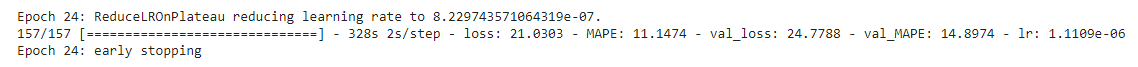

## График

In [ ]:
plot_history(history)

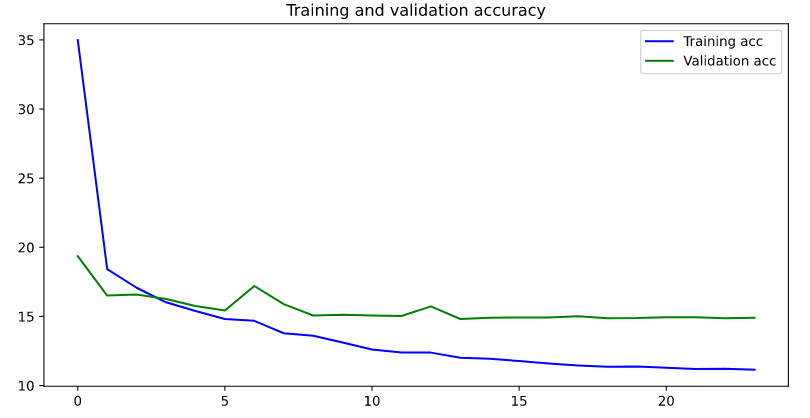

In [ ]:
model_mi = make_save(model_2mi, file_name)

## Валидация

In [ ]:
test_predict_2mi = np.round(model_2mi.predict([text_test_sequences, X_test]))
print(f"TEST mape: {(mape(y_test, predict_2mi[:,0]))*100:0.2f}%")

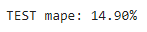

Сохраним предсказание для финального этапа.

In [ ]:
pd.DataFrame(test_predict_2mi).to_csv(os.path.join(path, 'test_predict_2mi.csv'), 
                                      index=False)

## Submission

In [ ]:
sample_submission = make_sub(model_2mi, sample_submission, 
                             [text_sub_sequences, sub], 
                             'mi_submission.csv')

## Промежуточный вывод

In [ ]:
raise KeyboardInterrupt

# Model 4: Tabular-text-image Multi Input network

## Подгружаем изображения

In [ ]:
# Укажем размер выводимого изображения
plt.figure(figsize=(10, 6))
# 9 случайных примеров из train
random_image = train.sample(n=9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values
# выведем 9 изображений автомобилей и цен к ним
for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(os.path.join(DATA_PATH,'img/img',str(path)+'.jpg'))
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Как видно, все вывелось корректно, никаких нареканий не имеется. Теперь загрузим все имеющиеся изображения с форматом 320х240:

In [ ]:
# Установим размер изображения
size = (320, 240)

# функция для загрузки изображений
def get_image_array(index):
    images_set = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(os.path.join(DATA_PATH,'img/img',str(sell_id)+'.jpg'))
        assert(image is not None)
        image = cv2.resize(image, size)  # изменение размера
        images_set.append(image)  # добавляем изображение в массив
    images_set = np.array(images_set)
    print('images shape', images_set.shape, 'dtype', images_set.dtype)
    return (images_set)


# применим функцию для создания выборок
images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(sub.index)

## Аугментация

Настройки, которые я использую для аугментации изображений, взяты из моего проекта [Ford vs Ferrari](https://www.kaggle.com/alexfoncrow/dst45-47-car-classification-sf/):

In [ ]:
augment_module = a.Compose([
    # добавляем размытие по Гауссу и шум с вероятностью 7%
    a.Blur(p=0.07),
    a.GaussNoise(p=0.07),
    #  параметры сдвига,поворота и масштабирования, а также их вероятность.
    a.ShiftScaleRotate(shift_limit=0.08,
                       scale_limit=0.05,
                       border_mode=4,
                       rotate_limit=20,
                       p=0.7),

    a.RGBShift(),
    a.HueSaturationValue(),  # случайный оттенок и насыщенность
    a.HorizontalFlip(),

    # установим случайную яркость и контрастность изображений с вероятностью 50%

    a.OneOf([
            a.RandomBrightnessContrast(
                brightness_limit=0.3, contrast_limit=0.3),
            a.RandomBrightnessContrast(brightness_limit=0.1, 
                                       contrast_limit=0.1)],
            p=0.3)
])

# Выведем пример аугментации
plt.figure(figsize=(12, 8))
for i in range(9):
    img = augment_module(image=images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
raise KeyboardInterrupt

## Использование tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

## Лемматизация

In [ ]:
morphy = pymorphy2.MorphAnalyzer()
df_NLP = data.copy()

In [ ]:
# функция для лемматизации текста:
def lemma(text):
    # Паттерн с символами
    trash_sym = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-–»«•∙·✔➥●☛“”°№₽®]+"

    text = text.lower()  # понижаем регистр
    text = re.sub(trash_sym, ' ', text)  # удаляем символы из паттерна
    strings = []  # создаем массив, в котором будут храниться лемматизированные строки
    for wrd in text.split():  # берем слово из строки
        wrd = wrd.strip()  # убираем пробелы до и после слова
        wrd = morphy.normal_forms(wrd)[0]  # приводим к нормальной форме
        strings.append(wrd)  # добавляем слово в строку массива
    return ' '.join(strings)  # вернем значения, разделив пробелами

In [ ]:
strings_set = []
strings_set = df_NLP.apply(
    lambda df_NLP: lemma(df_NLP['description']), axis=1)

In [ ]:
russian_stopwords = stopwords.words("russian")

In [ ]:
# функция для проверки на стоп-слова
def lineWithoutStopWords(line):
    line = line.split()  # разделяем на слова
    # возвращаем слово, если оно не в списке стоп-слов
    return [word for word in line if word not in russian_stopwords]


# применим функцию к нашим лемматизированым строкам слов
data['description'] = [lineWithoutStopWords(line) for line in strings_set]

## Загрузим обработанный description

In [ ]:
if os.path.exists(SAVE_PATH):
    data['description'] = pd.read_csv(os.path.join(SAVE_PATH, 
                                                  'processed_description.csv'))

In [ ]:
text_train = data['description'].iloc[X_train.index]
text_test = data['description'].iloc[X_test.index]
text_sub = data['description'].iloc[sub.index]

 ## Токенизация

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [ ]:
# обучение токенизатора для NLP
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data['description'])

Теперь создадим функции, которые будут применяться к имеющимся у нас данным:

In [ ]:
# аугментация изображений
def process_image(image):
    return augment_module(image=image.numpy())['image']


# векторизация строки
def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), 
                                  maxlen=MAX_SEQUENCE_LENGTH)


# применение векторизации к тексту
def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]


# функция  для применения вышеупомянутых функций 
# к входным данным обучающей выборки
def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image, ] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text, ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


# функция  для применения вышеупомянутых функций 
# к входным данным валидационной и тестовой выборкок
def tf_process_val_dataset_element(image, table_data, text, price):
    [text, ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


# использование tf.data.Dataset с использованием функций для обучающей выборки
train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data['description'].iloc[X_train.index], y_train
)).map(tf_process_train_dataset_element)

# использование tf.data.Dataset с использованием функций для валидационной выборки
test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data['description'].iloc[X_test.index], y_test
)).map(tf_process_val_dataset_element)

# использование tf.data.Dataset с использованием функций для тестовой выборки
y_sub = np.zeros(len(sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, sub, data['description'].iloc[sub.index], y_sub
)).map(tf_process_val_dataset_element)

# проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__()
test_dataset.__iter__().__next__()
sub_dataset.__iter__().__next__()

## DenseNet201

Загрузим исследуемую модель:

In [ ]:
# загрузим модель без "головы" и укажем, что она может обучаться
image_model = keras.applications.DenseNet201(
    weights='imagenet', include_top=False, input_shape=(size[1], size[0], 3))

image_model_output = L.GlobalAveragePooling2D()(image_model.output)

Заморозим 1\3 первых слоев модели:

In [ ]:
image_model.trainable = True
for layer in image_model.layers[:len(image_model.layers)//3]:
    layer.trainable = False

Посмотрим общее количество слоев в модели и какие из них могут обучаться:

In [ ]:
print(len(image_model.layers))

for layer in image_model.layers:
    print(layer, layer.trainable)

## NLP

In [ ]:
model_nlp = M.Sequential()

model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))

model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH))

model_nlp.add(L.LayerNormalization())

model_nlp.add(L.LSTM(128, return_sequences=True))
model_nlp.add(L.Dropout(0.15))

model_nlp.add(L.Dense(4096, 
                      kernel_regularizer=regularizers.l1_l2(l1=1e-7, l2=1e-7), 
                      kernel_initializer='normal', 
                      activation=ACTIVATION))
model_nlp.add(L.Dropout(0.15))

model_nlp.add(L.LSTM(128, return_sequences=True))
model_nlp.add(L.Dropout(0.15))

model_nlp.add(L.Dense(4096, 
                      kernel_regularizer=regularizers.l1_l2(l1=1e-7, l2=1e-7), 
                      kernel_initializer='normal', 
                      activation=ACTIVATION))
model_nlp.add(L.Dropout(0.15))

model_nlp.add(L.LSTM(128, return_sequences=True))
model_nlp.add(L.Dropout(0.15))

model_nlp.add(L.Dense(4096, 
                      kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
                      kernel_initializer='normal', 
                      activation=ACTIVATION))
model_nlp.add(L.Dropout(0.15))

model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.15))

model_nlp.add(L.Dense(8192, 
                      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-5), 
                      kernel_initializer='normal', 
                      activation=ACTIVATION))
# model_nlp.add(L.Dropout(0.15))

In [ ]:
# model_nlp = M.Sequential()

# model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))

# model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH))

# model_nlp.add(L.LayerNormalization())

# model_nlp.add(L.LSTM(64, return_sequences=True))
# model_nlp.add(L.Dropout(0.15))

# model_nlp.add(L.Dense(4096, 
#                       kernel_regularizer=regularizers.l1_l2(l1=1e-7, l2=1e-7), 
#                       kernel_initializer='normal', 
#                       activation=ACTIVATION))
# model_nlp.add(L.Dropout(0.15))

# model_nlp.add(L.LSTM(64, return_sequences=True))
# model_nlp.add(L.Dropout(0.15))

# model_nlp.add(L.Dense(4096, 
#                       kernel_regularizer=regularizers.l1_l2(l1=1e-7, l2=1e-7), 
#                       kernel_initializer='normal', 
#                       activation=ACTIVATION))
# model_nlp.add(L.Dropout(0.15))

# model_nlp.add(L.LSTM(64, return_sequences=True))
# model_nlp.add(L.Dropout(0.15))

# model_nlp.add(L.Dense(4096, 
#                       kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
#                       kernel_initializer='normal', 
#                       activation=ACTIVATION))
# model_nlp.add(L.Dropout(0.15))

# model_nlp.add(L.LSTM(128,))
# model_nlp.add(L.Dropout(0.15))

# model_nlp.add(L.Dense(4096, 
#                       kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-5), 
#                       kernel_initializer='normal', 
#                       activation=ACTIVATION))
# # model_nlp.add(L.Dropout(0.15))

## MLP

In [ ]:
model_mlp = M.Sequential()

model_mlp.add(L.Dense(4096, 
                       input_dim = X_train.shape[1],  
                       activation=ACTIVATION))
model_mlp.add(L.Dropout(0.15))

model_mlp.add(L.Dense(4096,
                       kernel_regularizer=regularizers.l1_l2(l1=1e-7, l2=1e-7), 
                       kernel_initializer='normal', 
                       activation=ACTIVATION))
model_mlp.add(L.Dropout(0.15))

model_mlp.add(L.Dense(4096,
                       kernel_regularizer=regularizers.l1_l2(l1=1e-7, l2=1e-7), 
                       kernel_initializer='normal', 
                       activation=ACTIVATION))
model_mlp.add(L.Dropout(0.15))

model_mlp.add(L.Dense(4096,
                       kernel_regularizer=regularizers.l1_l2(l1=1e-7, l2=1e-7), 
                       kernel_initializer='normal', 
                       activation=ACTIVATION))
model_mlp.add(L.Dropout(0.15))

model_mlp.add(L.Dense(4096,
                       kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
                       kernel_initializer='normal', 
                       activation=ACTIVATION))
model_mlp.add(L.Dropout(0.15))

model_mlp.add(L.Dense(4096,
                       kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
                       kernel_initializer='normal', 
                       activation=ACTIVATION))
model_mlp.add(L.Dropout(0.15))

model_mlp.add(L.Dense(4096,
                       kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-5), 
                       kernel_initializer='normal', 
                       activation=ACTIVATION))
model_mlp.add(L.Dropout(0.15))

model_mlp.add(L.Dense(8192,
                       kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-5), 
                       kernel_initializer='normal', 
                       activation=ACTIVATION))
# model_mlp.add(L.Dropout(0.15))

In [ ]:
# model_mlp = M.Sequential()

# model_mlp.add(L.Dense(4096, 
#                        input_dim = X_train.shape[1],  
#                        activation=ACTIVATION))
# model_mlp.add(L.Dropout(0.15))

# model_mlp.add(L.Dense(4096,
#                        kernel_regularizer=regularizers.l1_l2(l1=1e-7, l2=1e-7), 
#                        kernel_initializer='normal', 
#                        activation=ACTIVATION))
# model_mlp.add(L.Dropout(0.15))

# model_mlp.add(L.Dense(4096,
#                        kernel_regularizer=regularizers.l1_l2(l1=1e-7, l2=1e-7), 
#                        kernel_initializer='normal', 
#                        activation=ACTIVATION))
# model_mlp.add(L.Dropout(0.15))

# model_mlp.add(L.Dense(4096,
#                        kernel_regularizer=regularizers.l1_l2(l1=1e-7, l2=1e-7), 
#                        kernel_initializer='normal', 
#                        activation=ACTIVATION))
# model_mlp.add(L.Dropout(0.15))

# model_mlp.add(L.Dense(4096,
#                        kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-6), 
#                        kernel_initializer='normal', 
#                        activation=ACTIVATION))
# model_mlp.add(L.Dropout(0.15))

# model_mlp.add(L.Dense(8192,
#                        kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-5), 
#                        kernel_initializer='normal', 
#                        activation=ACTIVATION))
# # model_mlp.add(L.Dropout(0.15))

## Head

In [ ]:
# объединяем выходы трех нейросетей
combinedInput = L.concatenate(
    [image_model_output, model_mlp.output, model_nlp.output])

# being our regression head
head = L.Dense(4096, activation="linear")(combinedInput)
head = L.Dense(1,)(head)
# Соберем наши части в одну модель
model_3mi = M.Model(inputs=[image_model.input,
                      model_mlp.input, model_nlp.input], outputs=head)


## Summary

In [ ]:
model_3mi.summary()

In [ ]:
# raise KeyboardInterrupt

In [ ]:
LR = 0.0001

model_3mi.compile(loss='MAPE', optimizer=optimizers.Adam(learning_rate=LR),
                   metrics=['MAPE'])

In [ ]:
file_name = 'model_3mi'

## Коллбеки

In [ ]:
if is_colab:
    path = SAVE_PATH
else:
    path = WORK_PATH
                                                 
cb_checkpoint = ModelCheckpoint(os.path.join(path, 
                                                 file_name+'_best.hdf5'), 
                                    monitor = ['val_MAPE'], 
                                    verbose = 0, mode = 'min')

cb_earlystop = EarlyStopping(monitor='val_MAPE', patience=30, verbose=1, 
                             mode='min',
                             restore_best_weights=True)
# cb_schedul = LearningRateScheduler(scheduler, verbose=1)

cb_schedul = ReduceLROnPlateau(monitor='val_MAPE',
                                 factor=tf.math.exp(-0.1),  # new_lr = lp*factor
                                 patience=1,  # эпох без изменений
                                 min_lr=0.000000001,
                                 verbose=1,  # выводить сообщения
                                 mode='max')  # способ отслеживания метрики

callbacks_list = [cb_checkpoint, cb_earlystop, cb_schedul]

## Обучение

In [ ]:
BATCH_SIZE = 12

In [ ]:
history = model_3mi.fit(train_dataset.batch(BATCH_SIZE),
                    epochs=1000,
                    validation_data=test_dataset.batch(BATCH_SIZE),
                    callbacks=callbacks_list
                    )

## График

In [ ]:
plot_history(history)

In [ ]:
model_3mi = make_save(model_3mi, file_name)

## Валидация

In [ ]:
test_predict_3mi = np.round(model_3mi.predict(test_dataset.batch(BATCH_SIZE)))
print(f"TEST mape: {(mape(y_test, test_predict_3mi[:,0]))*100:0.2f}%")

Сохраним предсказание для финального этапа.

In [ ]:
pd.DataFrame(test_predict_3mi).to_csv(os.path.join(path, 'test_predict_3mi.csv'), 
                                      index=False)

## Submission

In [ ]:
# sub_predict_nn3 = model_3mi.predict(sub_dataset.batch(30))
# sample_submission['price'] = sub_predict_nn3[:, 0]
# sample_submission.to_csv('nn3_submission.csv', index=False)

sample_submission = make_sub(model_3mi, sample_submission, 
                             sub_dataset.batch(BATCH_SIZE), 
                             '3mi_submission.csv')

In [ ]:
raise KeyboardInterrupt

# Ансамблирование

В качестве конечного результата используем комбинацию из результатов предсказаний некоторых предыдущих моделей:
1. CatBoostRegressor
2. Табличная нейронная сеть
3. NLP+MLP+EffNetB6 Multi Input NN

## Загрузим модели


In [ ]:
# загрузить модели
model_catboost = CatBoostClassifier().load_model(os.path.join(path, 
                                                              'cat_boost_final'))
model_simple_dnn = keras.models.load_model(os.path.join(SAVE_PATH, 
                                                       'simple_dnn_final.hdf5'))
model_2mi = keras.models.load_model(os.path.join(SAVE_PATH, 
                                                       'model_2mi_final.hdf5'))
model_3mi = keras.models.load_model(os.path.join(SAVE_PATH, 
                                                       'model_3mi_final.hdf5'))

In [ ]:
# сделть предсказания
test_catboost_predictions = np.round(np.exp(cat_boost_model.predict(X_test)))
test_predict_3mi = np.round(model_3mi.predict(test_dataset.batch(BATCH_SIZE)))
test_predict_2mi = 
test_predict_simple_dnn = 

In [ ]:
# ансамблировать рпедсказания
test_ensemble_predict = 0.25*test_catboost_predictions \
                      + 0.25*test_predict_3mi \
                      + 0.25*test_predict_2mi \
                      + 0.25*test_predict_simple_dnn

test_ensemble_predict = np.round(test_ensemble_predict.argmax(axis=1))
print(f"TEST mape: {(mape(y_test, test_ensemble_predict))*100:0.2f}%")

Мы добились самой хорошей метрики, которая у нас была! На этом этапе сделаем финальный сабмит:

In [ ]:
# загрузить ранее сделанные сабмишны
catboost_predictions = 
predict_3mi = 
predict_2mi = 
predict_simple_dnn = 

In [ ]:
final_prediction = 0.25*catboost_predictions \
                 + 0.25*predict_3mi \
                 + 0.25*predict_2mi \
                 + 0.25*predict_simple_dnn

final_prediction = final_prediction.argmax(axis=1)

sample_submission = make_sub(model, sample_submission, 
                             ensemble_predict, 
                             '3mi_submission.csv')

# 9. Выводы

Как и в предыдущих проектах, скажу - я не уверен, что все параметры и архитектуры сетей подобраны лучшим образом, но результат получился хороший. Была проведена предварительная обработка данных, выделены новые фичи, которые использовались при обучении модели. Здесь хочется отметить, что лучшим решением было бы найти фичу, которая еще сильнее погасила бы взаимную корреляцию между столбцами model_time и productionDate. Я думаю, это бы привело к улучшению метрики.

Были исследованы различные способы обработки текста для RNN NLP. Здесь, возможно, стоило бы избавиться от используемых в тексте emoji, либо же применить, например, BERT. Насколько я успел прочитать, он очень хорошо справляется с поставленными задачами. Плюс На основе BERT можно создать модель, которая будет работать вместо нашей RNN NLP.

С табличными данными примерно та же история, вместо стандартной сборки модели можно использовать сеть TabNet. Насколько я изучил материал по ней, в большинстве задач она показывает себя очень хорошо при работе с табличными данными.

Для обработки изображений - есть множество вариантов - от изменения настроек и способа аугментации до изменения обучаемой нами модели. Для достоверности - лучше выбирать модель в соответствии с современными решениями, но не забывать про ограничение на используемой платформе.

Проект получился очень интересный, я узнал много различных вещей, которые могут помочь мне в дальнейшем. Также сформировал несколько вопросов, на которые бы очень хотелось получить ответ.

По результатам выполнения  проекта были получены следующие метрики MAPE:
1. CatBoostRegressor - 11.87%
2. Smiple Dense NN - 11.36%
3. MLP + RNN NLP  - 11.38%
4. MLP + NLP + EffNetB6 - 11.27%
5. Blending(1+2+4) - 10.87%